In [1]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  Siren
from implicit_learning.dataset import PoissonEqnRGB
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [2]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqnRGB(config, transform=transform)
    valid = PoissonEqnRGB(config, transform=transform)
    test  = PoissonEqnRGB(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader


class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config):
        self.lr = config.get("lr")
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.print_epoch = config.get("print_epoch")
        self.sidelength = config.get("sidelength")

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                        lr_lambda=lambda epoch: 1/(1000+((epoch))),
                                        last_epoch=-1,
                                        verbose=False)

    def train(self):
        for epoch in range(self.epochs):
            inputs = self.model_input

            self.optimizer.zero_grad() 
            outputs, coords =self.model(inputs)
            self.loss = self.compute_loss(outputs, coords) 

            if epoch %  self.print_epoch == 0:
                print("Epoch %4d"%(epoch), f" : Loss : {self.loss}")
                img_grad = [] 
                for i in range(outputs.size(-1)):
                    img_grad.append(gradient(outputs[:,:,i], coords))
                img_grad = torch.stack(img_grad)
                self.plot(outputs, self.gt['pixels'], img_grad, self.gt)
            self.loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def compute_loss(self, outputs, coords):
        train_loss = self.gradients_mse(outputs, coords, self.gt['grads'])
        return train_loss 

    def gradients_mse(self, model_output, coords, gt_gradients):
        # compute gradients on the model
        gradients = [] 
        for i in range(model_output.size(-1)):
            gradients.append(gradient(model_output[:,:,i].unsqueeze(-1), coords))
        gradients = torch.stack(gradients).view(1, -1, 2, model_output.size(-1))
        gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
        return gradients_loss

    def plot(self, model_output, original, img_grad, gt):
        fig, axes = plt.subplots(1, 4, figsize=(8, 3))

        # print(gt['grads'].cpu().norm(dim=-2).view(self.sidelength,self.sidelength,-1).detach().numpy().shape)
        # print(img_grad.cpu().norm(dim=-2).view(self.sidelength,self.sidelength,-1).detach().numpy().shape)
        axes[0].imshow(model_output.cpu().view(self.sidelength,self.sidelength,-1).detach().numpy())
        axes[1].imshow(original.cpu().view(self.sidelength,self.sidelength,-1).detach().numpy())
        # axes[2].imshow(img_grad.cpu().norm(dim=-2).view(self.sidelength,self.sidelength,-1).detach().numpy())
        # axes[3].imshow(gt['grads'].cpu().norm(dim=-2).view(self.sidelength,self.sidelength,-1).detach().numpy())
        
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch    0  : Loss : 153.33596801757812


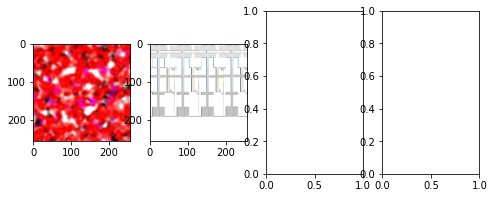

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch  100  : Loss : 10.481613159179688


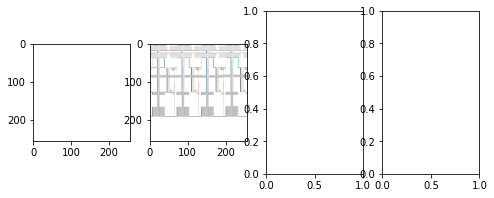

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch  200  : Loss : 4.823631286621094


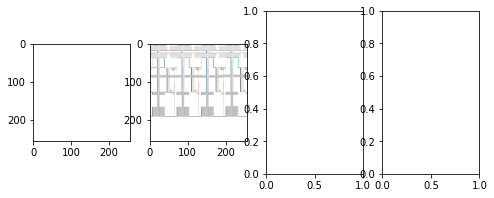

In [3]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":256,
        "hidden_layers":5,
        "out_features":4
    },
    "sidelength":256,
    "epochs":10000,
    "lr":0.1,
    "batch_size":1,
    "data-path":"../../data/medium.png",
    "print_epoch":100
}

model = Siren(**config['model'])
model.cuda()
trainer = CustomizeTrainer(model, *construct_dataloader(config), config)

trainer.train()
